In [0]:
from google.colab import files
uploaded = files.upload()

Saving agenda.json to agenda.json


In [0]:
pip install tqdm --upgrade

     |████████████████████████████████| 61kB 1.0MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize 
import matplotlib
from matplotlib import pyplot as plt
from pprint import pprint
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import nltk
import json
import string
import gensim
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
cores = multiprocessing.cpu_count()
from tqdm import tqdm
from sklearn.cluster import Birch

tqdm.pandas(desc="progress-bar")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def loadData(sentences_file,agendas_file):
  sentences=[]
  agendas=[]
  with open(sentences_file) as train_file:
    dict_train = json.load(train_file)
  with open(agendas_file) as train_file2:
    dict_train2=json.load(train_file2)

  for i in dict_train['structured_meeting_texts_without_introduction']:
    sentences.append(i['sentence'])

  for i in dict_train2['structured_agenda_texts']:
    for j in dict_train2['structured_agenda_texts'][i]:
      agendas.append(j['text'])
  return sentences,agendas

In [0]:
def filterEmptyStrings(arr):
  arr = list(filter(None, arr))
  return arr

In [0]:
def filterFunc(arr,func):
  arr = list(map(func,arr))
  return arr

In [0]:
def remove_punctuation(text):
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

In [0]:
def remove_stopwords(text):
  sw = stopwords.words('english')
  text = [word.lower() for word in text.split() if word.lower() not in sw]
  return " ".join(text)

In [0]:
def stemming(text):
  text = [stemmer.stem(word) for word in text.split()]
  return " ".join(text) 

In [0]:
def preprocessing(arr):
  arr=filterFunc(arr,remove_punctuation)
  arr=filterFunc(arr,remove_stopwords)
  arr=filterEmptyStrings(arr)

  return arr



In [0]:
def convertToVec(arr,vectorizer):
  X=vectorizer.fit_transform(arr)
  return X,vectorizer

In [0]:
def convertAgendasForModel(agendas,vectorizer):
  X=vectorizer.transform(agendas)
  return X,vectroizer

In [0]:
def convertToDoc2Vec(arr):
  documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(arr)]
  model =Doc2Vec(documents,dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
  start_alpha=0.01
  infer_epoch=1000
  X=[]
  for d in arr:
    X.append( model.infer_vector(d, alpha=start_alpha, steps=infer_epoch) )
  return X

In [0]:
def clustering(n_clusters,X,sentences_test,model):
  y=model.fit_predict(X)

  clusters={}
  for i in range(0,len(y)):
    if(str(y[i]) not in clusters): clusters[str(y[i])]=[]
    clusters[str(y[i])].append(sentences_test[i])
  return clusters,y


In [0]:
def plot_graph(num_alg,num_approach,plot_dict):
  fig, axs = plt.subplots(num_alg*num_approach,figsize=(17,25))
  fig.subplots_adjust(hspace=1)
  i=0
  for key in plot_dict:
    if(i<len(axs)):
      sns.countplot(plot_dict[key],ax=axs[i]).set_title(key)
    i+=1

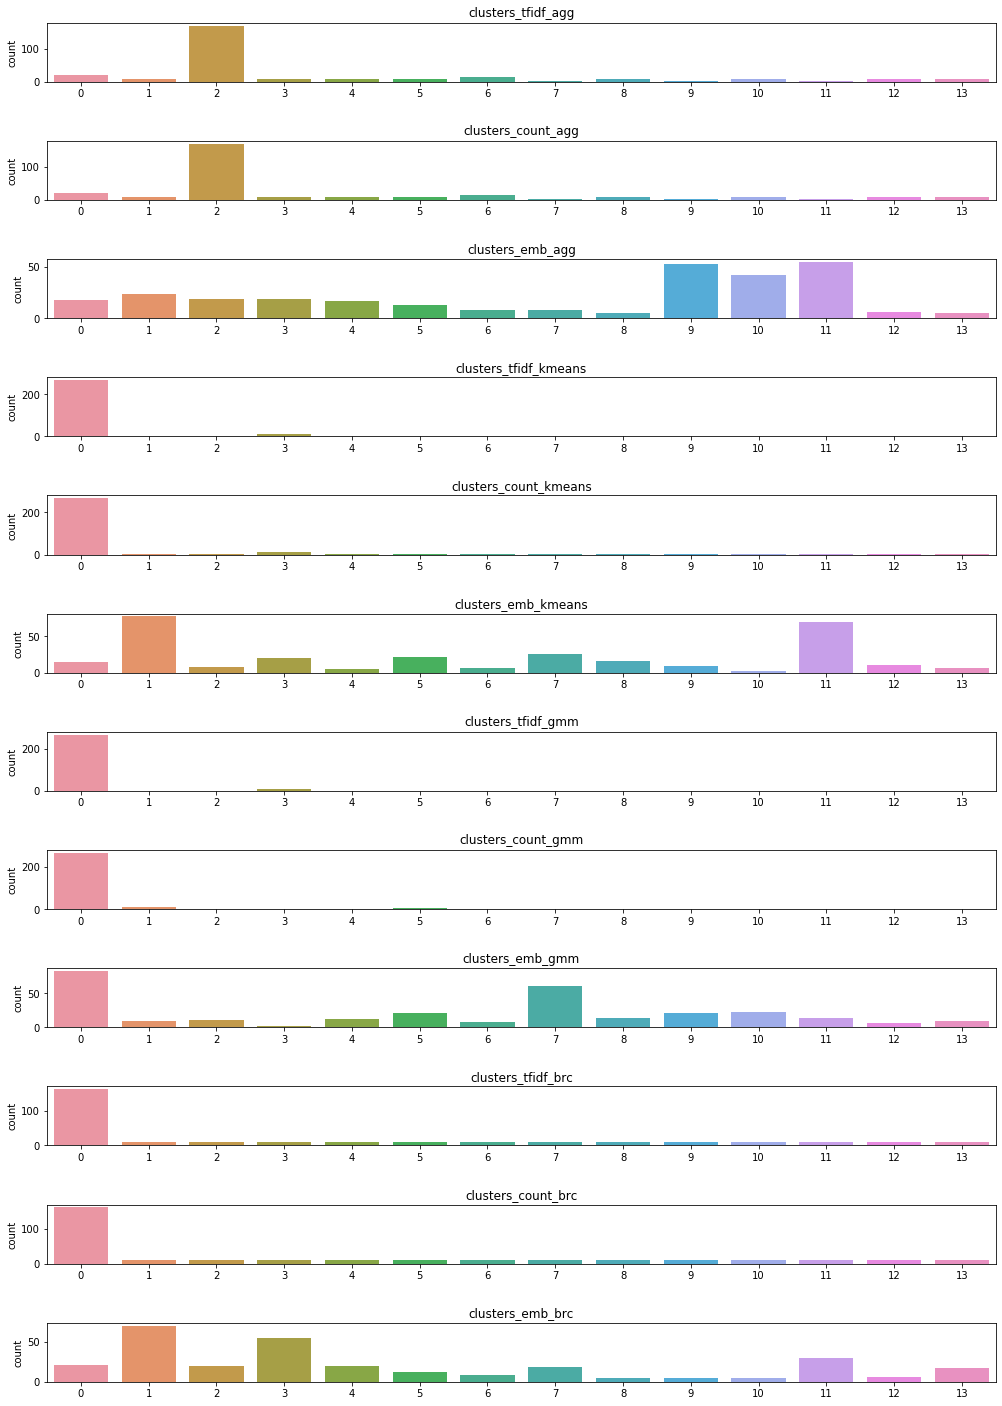

In [0]:

agendaFile="agenda.json"
sentenceFile="sentences2.json"

sentences,agendas=loadData(sentenceFile,agendaFile)
sentences_test=sentences
agendas_test=agendas
sentences=preprocessing(sentences)
agendas=preprocessing(agendas)
num_clusters=len(agendas)
predictions_dict={}

tfidf_vectorizer=TfidfVectorizer(tokenizer=sent_tokenize)
count_vectorizer=CountVectorizer(tokenizer=sent_tokenize)
tfidfVec,tfidf_vectorizer=convertToVec(sentences,tfidf_vectorizer)
countVec,count_vectorizer=convertToVec(sentences,count_vectorizer)
doc2Vec=convertToDoc2Vec(sentences)

agg= AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
clusters_tfidf_agg,pred=clustering(num_clusters,tfidfVec.toarray(),sentences_test,agg)
predictions_dict["clusters_tfidf_agg"]=pred
clusters_count_agg,pred=clustering(num_clusters,countVec.toarray(),sentences_test,agg)
predictions_dict["clusters_count_agg"]=pred
clusters_emb_agg,pred=clustering(num_clusters,doc2Vec,sentences_test,agg)
predictions_dict["clusters_emb_agg"]=pred


kmeans = KMeans(n_clusters = num_clusters,n_jobs = 1,max_iter=1000,n_init=10,random_state=0)
clusters_tfidf_kmeans,pred=clustering(num_clusters,tfidfVec,sentences_test,kmeans)
predictions_dict["clusters_tfidf_kmeans"]=pred
clusters_count_kmeans,pred=clustering(num_clusters,countVec,sentences_test,kmeans)
predictions_dict["clusters_count_kmeans"]=pred
clusters_emb_kmeans,pred=clustering(num_clusters,doc2Vec,sentences_test,kmeans)
predictions_dict["clusters_emb_kmeans"]=pred


gmm=GMM(n_components=num_clusters)
clusters_tfidf_gmm,pred=clustering(num_clusters,tfidfVec.toarray(),sentences_test,gmm)
predictions_dict["clusters_tfidf_gmm"]=pred
clusters_count_gmm,pred=clustering(num_clusters,countVec.toarray(),sentences_test,gmm)
predictions_dict["clusters_count_gmm"]=pred
clusters_emb_gmm,pred=clustering(num_clusters,doc2Vec,sentences_test,gmm)
predictions_dict["clusters_emb_gmm"]=pred


brc=Birch(n_clusters=num_clusters, threshold=0.1)
clusters_tfidf_brc,pred=clustering(num_clusters,tfidfVec.toarray(),sentences_test,brc)
predictions_dict["clusters_tfidf_brc"]=pred
clusters_count_brc,pred=clustering(num_clusters,countVec.toarray(),sentences_test,brc)
predictions_dict["clusters_count_brc"]=pred
clusters_emb_brc,pred=clustering(num_clusters,doc2Vec,sentences_test,brc)
predictions_dict["clusters_emb_brc"]=pred




plot_graph(4,3,predictions_dict)

In [0]:
from google.colab import files
def download_json(technique,clusters):
  with open('clusters-'+technique+'.json', 'w') as fp:
    json.dump(clusters, fp)
  files.download('clusters-'+technique+'.json')
download_json('clusters_tfidf_agg',clusters_tfidf_agg)
download_json('clusters_count_agg',clusters_count_agg)
download_json('clusters_emb_agg',clusters_emb_agg)
download_json('clusters_tfidf_kmeans',clusters_tfidf_kmeans)
download_json('clusters_count_kmeans',clusters_count_kmeans)
download_json('clusters_emb_kmeans',clusters_emb_kmeans)
download_json('clusters_tfidf_gmm',clusters_tfidf_gmm)
download_json('clusters_count_gmm',clusters_count_gmm)
download_json('clusters_emb_gmm',clusters_emb_gmm)